In [1]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np
import pandas as pd
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 512  # Latent dimensionality of the encoding space.
# Path to the data txt file on disk.
num_samples=100000
data_path = 'questions.txt'

Using TensorFlow backend.
D:\Anaconda3\envs\nanoscopy\lib\site-packages\tensorflow-1.13.1-py3.6-win-amd64.egg\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\nanoscopy\lib\site-packages\tensorflow-1.13.1-py3.6-win-amd64.egg\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\nanoscopy\lib\site-packages\tensorflow-1.13.1-py3.6-win-amd64.egg\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qi

In [2]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text,qty = line.split(',')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + " "+qty + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [3]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 29631
Number of unique input tokens: 27
Number of unique output tokens: 30
Max sequence length for inputs: 33
Max sequence length for outputs: 45


In [4]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 23704 samples, validate on 5927 samples
Epoch 1/100
23704/23704 [==============================] - 237s 10ms/step - loss: 0.9106 - acc: 0.7395 - val_loss: 0.2989 - val_acc: 0.8923
Epoch 2/100
23704/23704 [==============================] - 235s 10ms/step - loss: 0.1974 - acc: 0.9289 - val_loss: 0.1527 - val_acc: 0.9435
Epoch 3/100
23704/23704 [==============================] - 234s 10ms/step - loss: 0.1513 - acc: 0.9398 - val_loss: 0.1318 - val_acc: 0.9482
Epoch 4/100
23704/23704 [==============================] - 235s 10ms/step - loss: 0.1223 - acc: 0.9502 - val_loss: 0.1123 - val_acc: 0.9565
Epoch 5/100
23704/23704 [==============================] - 235s 10ms/step - loss: 0.0986 - acc: 0.9605 - val_loss: 0.0777 - val_acc: 0.9690
Epoch 6/100
23704/23704 [============================

23704/23704 [==============================] - 236s 10ms/step - loss: 1.2234e-07 - acc: 1.0000 - val_loss: 1.1950e-07 - val_acc: 1.0000
Epoch 51/100
23704/23704 [==============================] - 236s 10ms/step - loss: 1.2201e-07 - acc: 1.0000 - val_loss: 1.1942e-07 - val_acc: 1.0000
Epoch 52/100
23704/23704 [==============================] - 236s 10ms/step - loss: 1.2175e-07 - acc: 1.0000 - val_loss: 1.1939e-07 - val_acc: 1.0000
Epoch 53/100
23704/23704 [==============================] - 237s 10ms/step - loss: 1.2152e-07 - acc: 1.0000 - val_loss: 1.1935e-07 - val_acc: 1.0000
Epoch 54/100
23704/23704 [==============================] - 236s 10ms/step - loss: 1.2133e-07 - acc: 1.0000 - val_loss: 1.1932e-07 - val_acc: 1.0000
Epoch 55/100
23704/23704 [==============================] - 236s 10ms/step - loss: 1.2117e-07 - acc: 1.0000 - val_loss: 1.1929e-07 - val_acc: 1.0000
Epoch 56/100
23704/23704 [==============================] - 236s 10ms/step - loss: 1.2104e-07 - acc: 1.0000 - val_loss:

D:\Anaconda3\envs\nanoscopy\lib\site-packages\keras\engine\topology.py:2379: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


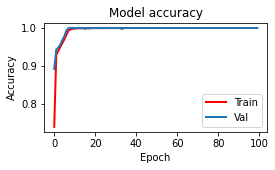

In [11]:
import keras
from matplotlib import pyplot as plt
plt.figure(figsize=(4,2))
plt.plot(history.history['acc'],color='red',linewidth=2)
plt.plot(history.history['val_acc'],linewidth=2)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
fig=plt.gcf()
plt.show()
fig.savefig('accuracy_lstm.png',dpi=300)

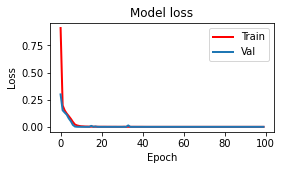

In [12]:
plt.figure(figsize=(4,2))
plt.plot(history.history['loss'],color='red',linewidth=2)
plt.plot(history.history['val_loss'],linewidth=2)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
fig=plt.gcf()
plt.show()
fig.savefig('loss_lstm.png',dpi=300)

In [31]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: there are nine pumpkins
Decoded sentence: how many pumpkins are there? nine

-
Input sentence: there are one mango
Decoded sentence: how many mangos are there? one

-
Input sentence: there are four rabbits
Decoded sentence: how many rabbits are there? four

-
Input sentence: there are three oranges
Decoded sentence: how many oranges are there? three

-
Input sentence: there are two icecreams
Decoded sentence: how many icecreams are there? two

-
Input sentence: there are five eapots
Decoded sentence: how many eapots are there? five

-
Input sentence: there are one cow
Decoded sentence: how many cows are there? one

-
Input sentence: there are nine cupcakes
Decoded sentence: how many cupcakes are there? nine

-
Input sentence: there are three umbrellas
Decoded sentence: how many umbrellas are there? three

-
Input sentence: there are four balloons
Decoded sentence: how many balloons are there? four

-
Input sentence: there are four ducks
Decoded sentence: how many duck

-
Input sentence: there are two lollipops
Decoded sentence: how many lollipops are there? two

-
Input sentence: there are one spider
Decoded sentence: how many spiders are there? one

-
Input sentence: there are three bananas
Decoded sentence: how many bananas are there? three

-
Input sentence: there are six mangos
Decoded sentence: how many mangos are there? six

-
Input sentence: there are three pencils
Decoded sentence: how many pencils are there? three

-
Input sentence: there are one lollipop
Decoded sentence: how many lollipops are there? one

-
Input sentence: there are two oranges
Decoded sentence: how many oranges are there? two

-
Input sentence: there are five balls
Decoded sentence: how many balls are there? five

